In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
import pandas as pd
import seaborn as sns
import xarray as xr
from scipy import stats


sys.path.append('/home/sachin/miniconda3/envs/torch_env/') #sever
from esn_dts_openloop import ESN, Tikhonov

In [2]:
ds = xr.open_dataset('/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/ampere_omni_2009_2021_5min.nc')
#ds['doy_sin'] = np.sin(2*np.pi*ds['doy']/365)
#s['doy_cos'] = np.cos(2*np.pi*ds['doy']/365)
#s['mlt_sin'] = np.sin(2*np.pi*ds['mlt']/24)
#ds['mlt_cos'] = np.cos(2*np.pi*ds['mlt']/24)
ds

<xarray.Dataset> Size: 10GB
Dimensions:         (dt: 1058064, mlat: 50, mlt: 24)
Coordinates:
  * dt              (dt) datetime64[ns] 8MB 2009-12-01 ... 2021-12-31T23:50:00
  * mlat            (mlat) float64 400B 40.0 41.02 42.04 ... 87.96 88.98 90.0
  * mlt             (mlt) float64 192B 0.0 1.043 2.087 3.13 ... 21.91 22.96 24.0
Data variables:
    jPar            (dt, mlat, mlt) float64 10GB ...
    BX_GSE          (dt) float64 8MB ...
    BY_GSE          (dt) float64 8MB ...
    BZ_GSE          (dt) float64 8MB ...
    flow_speed      (dt) int32 4MB ...
    proton_density  (dt) float64 8MB ...
    F10.7           (dt) int32 4MB ...
    Kp              (dt) int32 4MB ...
    doy             (dt) int32 4MB ...

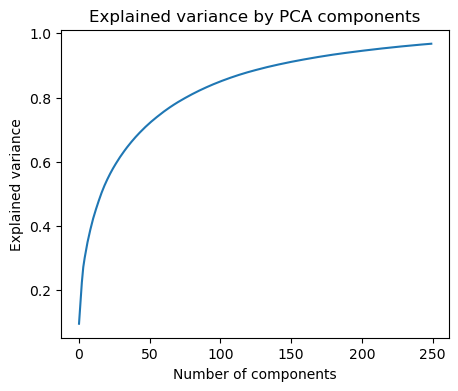

In [3]:
def create_PCA(ds, pca_comps, plot=False):

    ds = ds.copy()

    #reshape the data to be 2D
    ds_arr = ds['jPar'].values
    ds_arr = ds_arr.reshape(ds_arr.shape[0], -1)

    #create PCA object with the number of components
    pca = PCA(n_components=pca_comps)
    pca.fit(ds_arr)
    pickle.dump(pca, open('lstm_ampere_pca.pkl', 'wb'))
    reduced = pca.transform(ds_arr) #transform the data into the PCA space

    #return data to original space
    #inverse_transform = pca.inverse_transform(reduced)
    #print(inverse_transform.shape)

    if plot == True:
        # Plot the explained variance
        plt.figure(figsize=(5, 4))
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
        plt.xlabel('Number of components')
        plt.ylabel('Explained variance')
        plt.title('Explained variance by PCA components')
        plt.show()
    
    #return ds
    ds_pca = xr.Dataset({'jPar': (['dt', 'PC'], reduced)},
                        coords={'dt': ds['dt'], 'PC': np.arange(1, pca_comps+1)})
    
    ds_pca['BX_GSE'] = ds['BX_GSE']
    ds_pca['BY_GSE'] = ds['BY_GSE']
    ds_pca['BZ_GSE'] = ds['BZ_GSE']
    ds_pca['flow_speed'] = ds['flow_speed']
    ds_pca['proton_density'] = ds['proton_density']
    ds_pca['F10.7'] = ds['F10.7']
    #ds_pca['Kp'] = ds['Kp']
    ds_pca['doy'] = ds['doy']
    #ds_pca['doy_cos'] = ds['doy_cos']

    return ds_pca, pca

pca_comps = 250
ds, pca = create_PCA(ds, pca_comps, plot=True)

In [4]:
def simple_time_series_split(ds, train_ratio=0.90):

    # Calculate split indices
    train_idx = int(1058064 * train_ratio)

    train_slice = slice(0, train_idx)
    test_slice = slice(train_idx, None)

    ds_train = ds.isel(dt=train_slice)
    ds_test = ds.isel(dt=test_slice)

    X_train = ds_train.drop_vars('jPar').to_array().values.T
    y_train = ds_train['jPar'].values
    X_test = ds_test.drop_vars('jPar').to_array().values.T
    y_test = ds_test['jPar'].values
    
    return X_train, X_test, y_train, y_test, ds_test

X_train, X_test, y_train, y_test, ds_test = simple_time_series_split(ds)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((952257, 7), (105807, 7), (952257, 250), (105807, 250))

Define ESN

In [5]:
input_dim = X_train.shape[1] #number of input features
output_dim = y_train.shape[1] #number of output features
reservoir_size = 450 #number of reservoir neurons (Nodes in graph)
density = 0.2 #connection density (Edges in the graph)
input_scaling = 0.1 #scaling of input weights
spectral_radius = 0.99 #spectral radius of the recurrent matrix
beta = 1e-2 #regularization factor

In [6]:
model = ESN(input_dim, output_dim, reservoir_size, density, input_scaling, spectral_radius)
optimizer = Tikhonov(input_dim, reservoir_size, output_dim, beta=beta)
model.train(X_train, y_train, optimizer)

array([[  37.26053893, -894.63265084,  395.20559486, ...,  137.13689174,
         294.44844569, -254.66899573],
       [  41.82123342, -895.48359894,  394.50016348, ...,  136.23554722,
         296.19365586, -247.76305558],
       [  41.85653758, -895.70584065,  395.68091996, ...,  137.41893924,
         297.09780119, -248.01392644],
       ...,
       [  52.19835197, -930.13094303,  412.92101583, ...,  119.01075304,
         310.91911391, -271.39880938],
       [  52.73311888, -926.76872709,  412.22377913, ...,  115.08159658,
         310.97833778, -273.66834468],
       [  52.7144246 , -924.91796529,  411.88315553, ...,  113.32387201,
         310.41043654, -273.65755623]])

In [7]:
#make prediction on the test data
y_pred = model.predict(X_test)

#inverse transform the data / return to the original space
y_pred_orig = pca.inverse_transform(y_pred)
y_pred_orig = y_pred_orig.reshape(-1, 50, 24) #reshape the prediction to lat, lon
y_test_orig = pca.inverse_transform(y_test)
y_test_orig = y_test_orig.reshape(-1, 50, 24) #reshape the prediction to lat, lon

ds_test['jPar_pred'] = (['dt', 'mlat', 'mlt'], y_pred_orig)
ds_test['jPar_true'] = (['dt', 'mlat', 'mlt'], y_test_orig)

In [8]:
RMSE = np.sqrt(np.mean((y_pred_orig - y_test_orig)**2))
NRMSE = RMSE / (np.max(y_test_orig) - np.min(y_test_orig))
MAE = np.mean(np.abs(y_pred_orig - y_test_orig))
R = np.corrcoef(y_pred_orig.flatten(), y_test_orig.flatten())[0, 1]

print(f'RMSE: {RMSE:.3f}, NRMSE: {NRMSE:.3f}, MAE: {MAE:.2f}, R: {R:.2f}')

RMSE: 0.128, NRMSE: 0.004, MAE: 0.07, R: 0.41


### Make Predictions

In [9]:
predictions = []
for i in range(len(X_test)):
    pred = best_model(X_test[i].unsqueeze(0))
    predictions.append(pred.cpu().detach().numpy())

predictions_detach = np.squeeze(np.array(predictions))

NameError: name 'best_model' is not defined

### Calulate Global Scores

In [ ]:
RMSE = np.sqrt(np.mean((y_test.cpu().numpy() - predictions_detach)**2))
NRMSE = RMSE / (y_test.cpu().numpy().max() - y_test.cpu().numpy().min())
MAE = np.mean(np.abs(y_test.cpu().numpy() - predictions_detach))
R = np.corrcoef(y_test.cpu().numpy().flatten(), predictions_detach.flatten())[0, 1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / np.sum((o - np.mean(o))**2))
    return skill      

PE = skill(predictions_detach, y_test.cpu().numpy())

print(f'RMSE: {RMSE:.4f}, NRMSE: {NRMSE:.4f}, MAE: {MAE:.4f}, R: {R:.4f}, Skill: {PE:.4f}')

### Daily Predictions

In [ ]:
def open_multiple_nc(nc_files):
    ds = xr.open_mfdataset(nc_files, concat_dim='dt', combine='nested', parallel=True)
    ds['doy_sin'] = np.sin(2*np.pi*ds['doy']/365)
    ds['doy_cos'] = np.cos(2*np.pi*ds['doy']/365)

    #average over 5min
    ds = ds.resample(dt='5min').mean()
    #ds = ds.interpolate_na(dim='dt')

    #ds = ds.sel(nRec=slice(16500, 17000))

    return ds

dir = '/home/sachin/Documents/NIPR/Research/Data/AMPERE/processed/excluded/*.nc'
open_multi_amp = open_multiple_nc(dir)
open_multi_amp

In [ ]:
def split_to_df(ds):
    ds = ds.copy()

    dt = ds['dt'].values.flatten()
    BX_GSE = ds['BX_GSE'].values.flatten() #1
    BY_GSE = ds['BY_GSE'].values.flatten() #2
    BZ_GSE = ds['BZ_GSE'].values.flatten() #3
    flow_speed = ds['flow_speed'].values.flatten() #4
    proton_density = ds['proton_density'].values.flatten() #5
    doy_sin = ds['doy_sin'].values.flatten() #6
    doy_cos = ds['doy_cos'].values.flatten() #7
    
    #AL_INDEX = ds['AL_INDEX'].values.flatten() #6
    #AU_INDEX = ds['AU_INDEX'].values.flatten() #7
    #SYM_H = ds['SYM_H'].values.flatten() #8
    #ASY_H = ds['ASY_H'].values.flatten()  #9
    #F10_7 = ds['F10.7'].values.flatten() #10
    #Kp = ds['Kp'].values.flatten() #11

    #return BX_GSE.shape

    df_dict = {'dt':dt, 'BX_GSE': BX_GSE, 'BY_GSE': BY_GSE, 'BZ_GSE': BZ_GSE, 'flow_speed': flow_speed, 'proton_density': proton_density, 'doy_sin': doy_sin, 'doy_cos': doy_cos}
    df = pd.DataFrame(df_dict)
    
    df_2 = df.copy()
    df_2 = df_2.drop(columns=['dt'])

    return df, df_2

split_to_df(open_multi_amp)
df_raw, df_proc = split_to_df(open_multi_amp)
col_names = df_raw.columns

In [ ]:
norm_arr = input_scaler.transform(df_proc)

def create_sequences(arr, lookback=lookback):
    X = []
    for i in range(len(arr) - lookback):
        X.append(arr[i:i+lookback].T)

    X = np.array(X)

    return X

proc_seq = create_sequences(norm_arr)
raw_seq = create_sequences(df_raw.values)

In [ ]:
# Assuming best_model is already defined and loaded
device = torch.device('cpu')
best_model.to(device)  # Ensure the model is on the CPU
best_model.eval()

# Adjust the shape to match the model's expected input size
norm_proc = torch.tensor(proc_seq, dtype=torch.float32).to(device)
norm_proc = norm_proc.permute(0, 1, 2)  # Change from [848370, 11, 30] to [848370, 30, 11]

predictions = []

with torch.no_grad():
    for i in range(len(norm_proc)):
        output = best_model(norm_proc[i].unsqueeze(0))
        predictions.append(output)

predictions = torch.cat(predictions)
predictions = predictions.numpy()  # Tensor is already on CPU, no need to move again

In [ ]:
ds = xr.Dataset({'Jpar_pred': (['dt', 'mlat', 'mlt'], predictions),
                 'Jpar_true': (['dt', 'mlat', 'mlt'], open_multi_amp['jPar'].values[lookback:])},
                coords = {'dt': df_raw['dt'].values[lookback:], 'mlat': np.arange(40, 90, 1), 'mlt': np.arange(0, 24, 1)})
ds

In [ ]:
timestep = 83

R = np.corrcoef(ds['Jpar_pred'].isel(dt=timestep).values, ds['Jpar_true'].isel(dt=timestep).values)[1,0]
RMSE = np.sqrt(np.mean((ds['Jpar_pred'].isel(dt=timestep).values - ds['Jpar_true'].isel(dt=timestep).values)**2))
MAE = np.mean(np.abs(ds['Jpar_pred'].isel(dt=timestep).values - ds['Jpar_true'].isel(dt=timestep).values))
NRMSE = RMSE / (np.max(ds['Jpar_true'].isel(dt=timestep).values) - np.min(ds['Jpar_true'].isel(dt=timestep).values))

print(f'R: {R:.3f}, RMSE: {RMSE:.3f}, NRMSE: {NRMSE:.3f}, MAE: {MAE:.3f}')

In [ ]:
fac = ds['Jpar_pred'].isel(dt=timestep).values

def dt_to_str(dt):
    dt_1 = dt[0]
    dt_2 = dt[1] 
    time_1 = pd.to_datetime(dt_1)
    time_2 = pd.to_datetime(dt_2)
    str_time_1 = time_1.strftime('%Y-%m-%d %H:%M')
    str_time_2 = time_2.strftime('%Y-%m-%d %H:%M')

    return str_time_1, str_time_2

dt = ds['dt'].isel(dt=timestep).values
#start_time, end_time = dt_to_str(dt)

fac = fac.reshape(24, 50).T # reshape and transpose
fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 24) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(40, 90, 50) #convert to colat

cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
#cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-1, 1, 100))
ax.set_ylim([0,40])
ax.set_yticks([0, 10, 20, 30,40])
ax.set_yticklabels(["90°", "80°", "70°", "60°","50° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
ax.set_title(f"{dt}", pad=10, fontsize=11.5)


plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12, 
             ticks=[-1, -0.5, 0, 0.5, 1], 
             orientation='horizontal')

plt.tight_layout()

In [ ]:
fac = ds['Jpar_true'].isel(dt=timestep).values

def dt_to_str(dt):
    dt_1 = dt[0]
    dt_2 = dt[1] 
    time_1 = pd.to_datetime(dt_1)
    time_2 = pd.to_datetime(dt_2)
    str_time_1 = time_1.strftime('%Y-%m-%d %H:%M')
    str_time_2 = time_2.strftime('%Y-%m-%d %H:%M')

    return str_time_1, str_time_2

dt = ds['dt'].isel(dt=timestep).values
#start_time, end_time = dt_to_str(dt)

fac = fac.reshape(24, 50).T # reshape and transpose
fac = np.flipud(fac) # flip the array upside down
theta = np.linspace(0, 360, 24) - 90 # rotate by 90 degrees
theta = np.radians(theta) # convert to radians
r = 90 - np.linspace(40, 90, 50) #convert to colat

cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", ["blue","blue", "white", "white","red","red"])
#cmap = 'bwr'

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 5))

c = ax.contourf(theta, r, fac, cmap=cmap, levels=np.linspace(-1, 1, 100))
ax.set_ylim([0,40])
ax.set_yticks([0, 10, 20, 30,40])
ax.set_yticklabels(["90°", "80°", "70°", "60°","50° MLAT"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT \nMidnight", "3", "6 \n  Dawn", "9", "12 MLT \nMidday", "15", "18 \nDusk"])
ax.grid(True, linestyle='-.', alpha=0.7)
ax.set_title(f"{dt}", pad=10, fontsize=11.5)


plt.colorbar(c, ax=ax, label='J$_\parallel$ (FAC) [µA/m$^2$]', shrink=0.3, pad = 0.12, 
             ticks=[-1, -0.5, 0, 0.5,1], 
             orientation='horizontal')

plt.tight_layout()